ali535_ACO

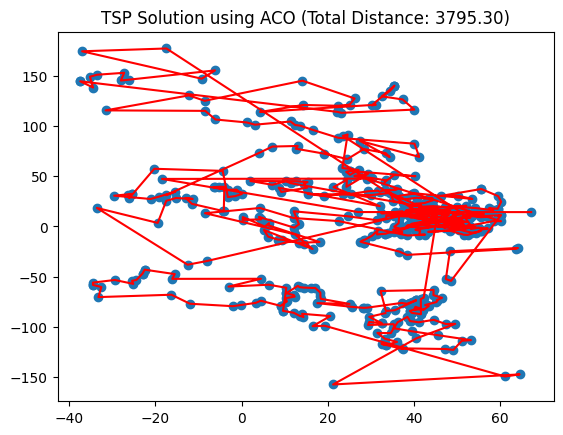

Time taken to render: 114.63196134567261 seconds




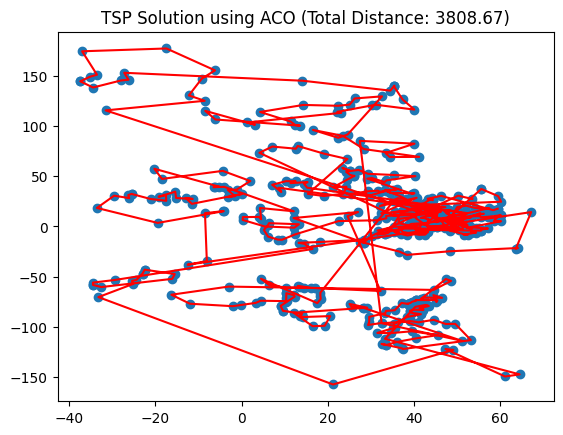

Time taken to render: 114.57496786117554 seconds


Average Tour Length: 3801.984692326865
Average Time taken to render: 114.60346460342407 seconds


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
import re

class AntColony:
    def __init__(self, points, colony_size=10, pheromone_evaporation_rate=0.5, alpha=1, beta=2, q=10, iterations=100):
        self.points = np.array(points)
        self.n = len(points)
        self.colony_size = colony_size
        self.pheromone_evaporation_rate = pheromone_evaporation_rate
        self.alpha = alpha
        self.beta = beta
        self.q = q
        self.iterations = iterations
        self.pheromone_matrix = np.ones((self.n, self.n))  # Initialize pheromone matrix
        self.best_tour = None
        self.best_tour_length = float('inf')

    def initialize_ants(self):
        self.ants = [[np.random.randint(0, self.n)] for _ in range(self.colony_size)]

    def select_next_city(self, ant, visited):
        pheromone_values = self.pheromone_matrix[ant[-1]] ** self.alpha
        visibility = 1 / (1 + np.linalg.norm(self.points - self.points[ant[-1]], axis=1))
        probabilities = pheromone_values * visibility
        probabilities[list(visited)] = 0
        probabilities /= probabilities.sum()
        selected_city = np.random.choice(range(self.n), p=probabilities)
        return selected_city

    def find_tour(self, ant):
        visited = set(ant)
        while len(visited) < self.n:
            next_city = self.select_next_city(ant, visited)
            ant.append(next_city)
            visited.add(next_city)
        return ant

    def update_pheromones(self):
        for i in range(self.n):
            for j in range(self.n):
                self.pheromone_matrix[i, j] *= (1 - self.pheromone_evaporation_rate)
        for ant in self.ants:
            tour_length = sum(np.linalg.norm(self.points[ant[i]] - self.points[ant[i + 1]]) for i in range(self.n - 1))
            tour_length += np.linalg.norm(self.points[ant[-1]] - self.points[ant[0]])
            for i in range(self.n - 1):
                self.pheromone_matrix[ant[i], ant[i + 1]] += self.q / tour_length
            self.pheromone_matrix[ant[-1], ant[0]] += self.q / tour_length

    def solve(self):
        for _ in range(self.iterations):
            self.initialize_ants()
            for ant in self.ants:
                ant = self.find_tour(ant)
                tour_length = sum(np.linalg.norm(self.points[ant[i]] - self.points[ant[i + 1]]) for i in range(self.n - 1))
                tour_length += np.linalg.norm(self.points[ant[-1]] - self.points[ant[0]])
                if tour_length < self.best_tour_length:
                    self.best_tour_length = tour_length
                    self.best_tour = ant
            self.update_pheromones()

# Specify the path to your TSP file
tsp_file_path = "ali535.tsp"

# Load the TSP dataset from the file
def load_tsp_file(file_path):
    with open(file_path, 'r') as file:
        tsp_data = file.read()
    return tsp_data

# Parse the TSP dataset and extract coordinates
def parse_tsp_dataset(data):
    coordinates = []
    pattern = re.compile(r'\s*(\d+)\s+(-?\d+\.\d+)\s+(-?\d+\.\d+)')

    in_node_coord_section = False
    for line in data.split('\n'):
        if line.startswith("NODE_COORD_SECTION"):
            in_node_coord_section = True
            continue
        if line.startswith("EOF"):
            break
        if in_node_coord_section:
            match = pattern.match(line)
            if match:
                coordinates.append((float(match.group(2)), float(match.group(3))))

    return coordinates

# Load the TSP dataset from a file
tsp_data = load_tsp_file(tsp_file_path)

# Parse the dataset and extract coordinates
city_coordinates = parse_tsp_dataset(tsp_data)

# Create AntColony instance and solve using ant colony optimization
total_distances = []
render_times = []

for i in range(2):
    start_time = time.time()  # Start timing for this run
    solver = AntColony(city_coordinates)
    solver.solve()
    total_distance = solver.best_tour_length
    total_distances.append(total_distance)
    # Plot the solution
    plt.figure()
    plt.scatter(solver.points[:, 0], solver.points[:, 1])
    tour_points = np.array([solver.points[i] for i in solver.best_tour])
    plt.plot(tour_points[:, 0], tour_points[:, 1], 'r-')
    plt.title(f'TSP Solution using ACO (Total Distance: {total_distance:.2f})')
    plt.show()

    end_time = time.time()  # End timing for this run
    rendered_time = end_time - start_time  # Calculate render time for this run
    render_times.append(rendered_time)
    print("Time taken to render:", rendered_time, "seconds\n\n")

# Calculate and print average tour length and average time taken to render
average_tour_length = np.mean(total_distances)
average_render_time = np.mean(render_times)
print("Average Tour Length:", average_tour_length)
print("Average Time taken to render:", average_render_time, "seconds")


ali535_SA

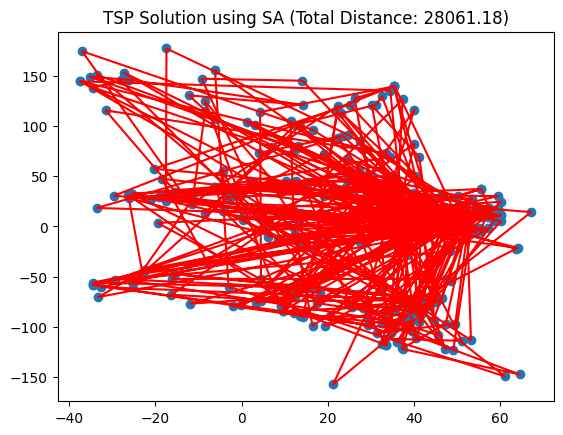

Time taken to render: 8.26663064956665 seconds




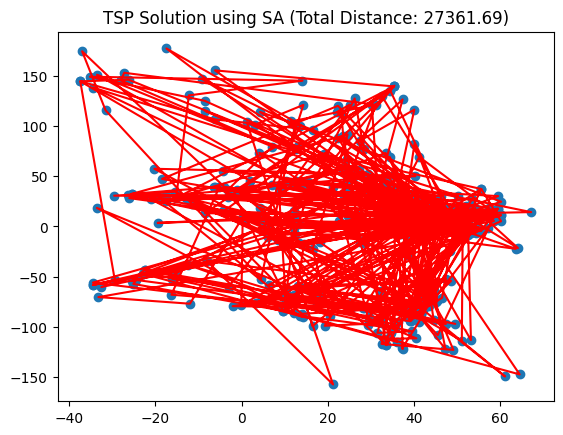

Time taken to render: 3.570033311843872 seconds




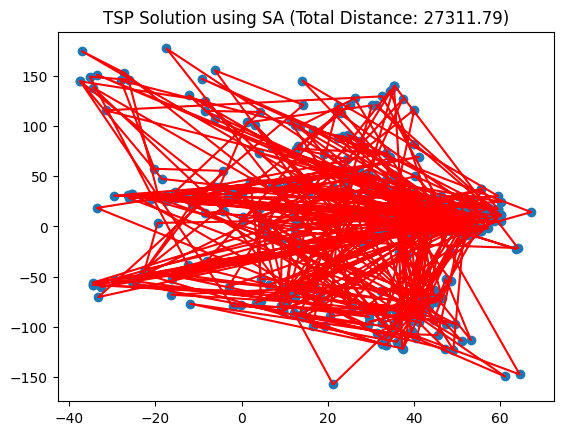

Time taken to render: 2.897371768951416 seconds


Average Tour Length: 27578.21851031072
Average Time taken to render: 4.9113452434539795 seconds


In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
import time
import math

class TSPSolver:
    def __init__(self, points):
        self.points = np.array(points)
        self.n = len(points)
        self.tour = None

    def initial_solution(self):
        return np.random.permutation(self.n)

    def acceptance_probability(self, old_cost, new_cost, temperature):
        if new_cost < old_cost:
            return 1.0
        return math.exp((old_cost - new_cost) / temperature)

    def simulated_annealing(self, initial_temperature=1000, cooling_rate=0.99, stopping_temperature=0.1):
        current_solution = self.initial_solution()
        current_cost = self.total_distance(current_solution)

        temperature = initial_temperature

        while temperature > stopping_temperature:
            new_solution = np.copy(current_solution)
            i, j = np.random.choice(self.n, size=2, replace=False)
            new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
            new_cost = self.total_distance(new_solution)

            if self.acceptance_probability(current_cost, new_cost, temperature) > np.random.rand():
                current_solution = new_solution
                current_cost = new_cost

            temperature *= cooling_rate

        self.tour = current_solution.tolist()

    def total_distance(self, tour):
        return sum(np.linalg.norm(self.points[tour[i]] - self.points[tour[i + 1]]) for i in range(self.n - 1))

    def solve(self):
        self.simulated_annealing()
        # Connect the last city back to the starting city to form a closed tour
        self.tour.append(self.tour[0])

# Parse the TSP dataset and extract coordinates
def parse_tsp_dataset(data):
    coordinates = []
    pattern = re.compile(r'\s*(\d+)\s+(-?\d+\.\d+)\s+(-?\d+\.\d+)')

    in_node_coord_section = False
    for line in data.split('\n'):
        if line.startswith("NODE_COORD_SECTION"):
            in_node_coord_section = True
            continue
        if line.startswith("EOF"):
            break
        if in_node_coord_section:
            match = pattern.match(line)
            if match:
                coordinates.append((float(match.group(2)), float(match.group(3))))

    return coordinates

# Load the TSP dataset from a file
def load_tsp_file(file_path):
    with open(file_path, 'r') as file:
        tsp_data = file.read()
    return tsp_data

# Specify the path to your TSP file
tsp_file_path = "ali535.tsp"

# Load the TSP dataset from the file
tsp_data = load_tsp_file(tsp_file_path)

# Parse the dataset and extract coordinates
city_coordinates = parse_tsp_dataset(tsp_data)

# Create TSPSolver instance and solve using simulated annealing
total_distances = []
render_times = []

for i in range(3):
    start_time = time.time()  # Start timing for this run
    solver = TSPSolver(city_coordinates)
    solver.solve()
    total_distance = solver.total_distance(solver.tour)
    total_distances.append(total_distance)
    # Plot the solution
    plt.figure()
    plt.scatter(solver.points[:, 0], solver.points[:, 1])
    tour_points = np.array([solver.points[i] for i in solver.tour])
    plt.plot(tour_points[:, 0], tour_points[:, 1], 'r-')
    plt.title(f'TSP Solution using SA (Total Distance: {total_distance:.2f})')
    plt.show()

    end_time = time.time()  # End timing for this run
    rendered_time = end_time - start_time  # Calculate render time for this run
    render_times.append(rendered_time)
    print("Time taken to render:", rendered_time, "seconds\n\n")

# Calculate and print average tour length and average time taken to render
average_tour_length = np.mean(total_distances)
average_render_time = np.mean(render_times)
print("Average Tour Length:", average_tour_length)
print("Average Time taken to render:", average_render_time, "seconds")


ali535_NIH

Iteration 21440: Improved total distance to 2368.39
Iteration 27336: Improved total distance to 2368.32
Iteration 32697: Improved total distance to 2364.00
Iteration 33768: Improved total distance to 2363.37
Iteration 41273: Improved total distance to 2362.83
Iteration 41808: Improved total distance to 2362.79
Iteration 46632: Improved total distance to 2362.66
Iteration 60033: Improved total distance to 2361.10
Iteration 62712: Improved total distance to 2356.13
Iteration 63784: Improved total distance to 2355.98
Iteration 76112: Improved total distance to 2355.39
Iteration 76113: Improved total distance to 2349.84
Iteration 83081: Improved total distance to 2347.80
Iteration 106670: Improved total distance to 2342.75
Iteration 107204: Improved total distance to 2332.29
Iteration 107738: Improved total distance to 2330.63
Iteration 108272: Improved total distance to 2328.46
Iteration 119528: Improved total distance to 2326.65
Iteration 148472: Improved total distance to 2325.81
Iterat

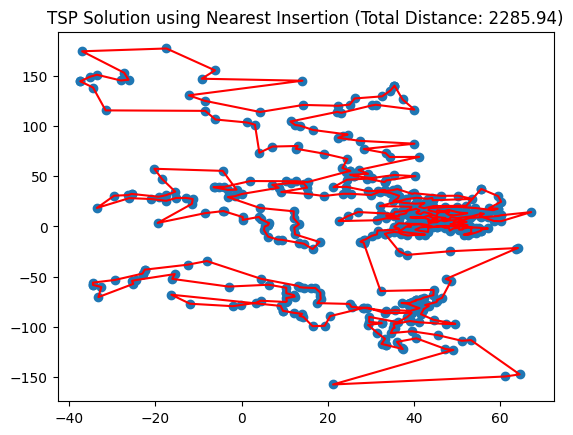

Time taken to render: 769.5202808380127 seconds


Iteration 1068: Improved total distance to 2390.38
Iteration 12328: Improved total distance to 2389.92
Iteration 14393: Improved total distance to 2388.93
Iteration 32166: Improved total distance to 2383.88
Iteration 32700: Improved total distance to 2373.42
Iteration 33234: Improved total distance to 2371.76
Iteration 33768: Improved total distance to 2369.59
Iteration 57352: Improved total distance to 2369.19
Iteration 58961: Improved total distance to 2364.88
Iteration 72360: Improved total distance to 2364.74
Iteration 81473: Improved total distance to 2363.48
Iteration 82008: Improved total distance to 2363.03
Iteration 88050: Improved total distance to 2362.27
Iteration 88585: Improved total distance to 2362.08
Iteration 89118: Improved total distance to 2360.88
Iteration 89119: Improved total distance to 2360.09
Iteration 89120: Improved total distance to 2356.77
Iteration 91120: Improved total distance to 2356.47
Iteration 92323

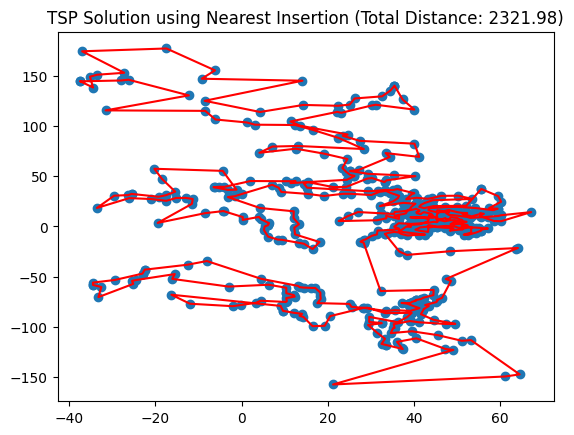

Time taken to render: 756.0393714904785 seconds


Average Tour Length: 2303.9641304702845
Average Time taken to render: 762.7798261642456 seconds


In [4]:
import re
import numpy as np
import matplotlib.pyplot as plt
import time

class TSPSolver:
    def __init__(self, points):
        self.points = np.array(points)
        self.n = len(points)
        self.tour = None

    def nearest_insertion(self, start=None):
        if start is None:
            start = np.random.randint(0, self.n)
        unvisited = set(range(self.n))
        unvisited.remove(start)
        tour = [start]

        while unvisited:
            min_distance = float('inf')
            min_city = None
            for i in range(len(tour)):
                for j in unvisited:
                    dist = np.linalg.norm(self.points[tour[i]] - self.points[j]) + np.linalg.norm(self.points[j] - self.points[tour[(i + 1) % len(tour)]]) - np.linalg.norm(self.points[tour[i]] - self.points[tour[(i + 1) % len(tour)]])
                    if dist < min_distance:
                        min_distance = dist
                        min_city = j
                        position = i + 1
            tour.insert(position, min_city)
            unvisited.remove(min_city)

        self.tour = tour

    def total_distance(self, tour=None):
        if tour is None:
            tour = self.tour
        return sum(np.linalg.norm(self.points[tour[i]] - self.points[tour[i + 1]]) for i in range(self.n - 1))

    def solve(self):
        self.nearest_insertion()
        # Connect the last city back to the starting city to form a closed tour
        self.tour.append(self.tour[0])
        prev_distance = self.total_distance()

        for i in range(1, self.n - 1):
            for j in range(i + 1, self.n):
                self.tour[i], self.tour[j] = self.tour[j], self.tour[i]
                new_distance = self.total_distance()
                if new_distance < prev_distance:
                    print(f"Iteration {i * self.n + j - 1}: Improved total distance to {new_distance:.2f}")
                    prev_distance = new_distance
                else:
                    self.tour[i], self.tour[j] = self.tour[j], self.tour[i]  # Revert back if the swap doesn't improve the distance

# Parse the TSP dataset and extract coordinates
def parse_tsp_dataset(data):
    coordinates = []
    pattern = re.compile(r'\s*(\d+)\s+(-?\d+\.\d+)\s+(-?\d+\.\d+)')

    in_node_coord_section = False
    for line in data.split('\n'):
        if line.startswith("NODE_COORD_SECTION"):
            in_node_coord_section = True
            continue
        if line.startswith("EOF"):
            break
        if in_node_coord_section:
            match = pattern.match(line)
            if match:
                coordinates.append((float(match.group(2)), float(match.group(3))))

    return coordinates

# Load the TSP dataset from a file
def load_tsp_file(file_path):
    with open(file_path, 'r') as file:
        tsp_data = file.read()
    return tsp_data

# Specify the path to your TSP file
tsp_file_path = "ali535.tsp"

# Load the TSP dataset from the file
tsp_data = load_tsp_file(tsp_file_path)

# Parse the dataset and extract coordinates
city_coordinates = parse_tsp_dataset(tsp_data)

# Create TSPSolver instance and solve using nearest insertion
total_distances = []
render_times = []

for i in range(2):
    start_time = time.time()  # Start timing for this run
    solver = TSPSolver(city_coordinates)
    solver.solve()
    total_distance = solver.total_distance()
    total_distances.append(total_distance)
    # Plot the solution
    plt.figure()
    plt.scatter(solver.points[:, 0], solver.points[:, 1])
    tour_points = np.array([solver.points[i] for i in solver.tour])
    plt.plot(tour_points[:, 0], tour_points[:, 1], 'r-')
    plt.title(f'TSP Solution using Nearest Insertion (Total Distance: {total_distance:.2f})')
    plt.show()

    end_time = time.time()  # End timing for this run
    rendered_time = end_time - start_time  # Calculate render time for this run
    render_times.append(rendered_time)
    print("Time taken to render:", rendered_time, "seconds\n\n")

# Calculate and print average tour length and average time taken to render
average_tour_length = np.mean(total_distances)
average_render_time = np.mean(render_times)
print("Average Tour Length:", average_tour_length)
print("Average Time taken to render:", average_render_time, "seconds")